# TCC Ciências de dados 

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


## Pré-processamento do texto

In [ ]:
import re
import nltk
import string
import numpy as np
from nltk.cluster.util import cosine_distance #similaridade do cosseno
from nltk.cluster.util import euclidean_distance #distância euclidiana utilizada pelo Knn (teste meu)
import networkx as nx
import pandas as pd
import random
import heapq
import seaborn as sns
import math
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Instalando a biblioteca spaCy

1.2   Importação de bibliotecas

In [ ]:
!pip install spacy==2.3.5

     |████████████████████████████████| 10.4MB 5.6MB/s 
     |████████████████████████████████| 1.1MB 34.8MB/s 
  Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
import spacy
pln = spacy.load("pt")

     |████████████████████████████████| 19.6MB 1.1MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.3.0-cp37-none-any.whl size=19557499 sha256=48e8edc4104dbde5f0dd762e79d629d0706389b251bb6891c93b7a364b46d952
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnk75vdz/wheels/f6/43/f6/949b5e2b48df37aa3ed81fc3f4af4154afa276518cc004b990
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('rslp') #stemização
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

# Avaliação na base de teste sumarizada com DCNN

## Sumarização Luhn

In [ ]:
def preprocessamento_luhn(texto):
  texto_formatado = texto.lower()
  tokens = []
  for token in nltk.word_tokenize(texto_formatado):
    tokens.append(token)

  tokens = [palavra for palavra in tokens if palavra not in stop_words and palavra not in string.punctuation]
  texto_formatado = ' '.join([str(elemento) for elemento in tokens if not elemento.isdigit()])
  return texto_formatado

In [ ]:
def calcula_nota_sentenca(sentencas, palavras_importantes, distancia):
  notas = []
  indice_sentenca = 0

  for sentenca in [nltk.word_tokenize(sentenca.lower()) for sentenca in sentencas]:
    indice_palavra = []
    for palavra in palavras_importantes:
      try:
        indice_palavra.append(sentenca.index(palavra))
      except ValueError:
        pass
    
    indice_palavra.sort()

    if len(indice_palavra) == 0:
      continue

    lista_grupos = []
    grupo = [indice_palavra[0]]
    i = 1
    while i < len(indice_palavra):
      if indice_palavra[i] - indice_palavra[i - 1] < distancia:
        grupo.append(indice_palavra[i])
      else:
        lista_grupos.append(grupo[:])
        grupo = [indice_palavra[i]]
      i += 1
    lista_grupos.append(grupo)

    nota_maxima_grupo = 0
    for g in lista_grupos:
      palavras_importantes_no_grupo = len(g)
      total_palavras_no_grupo = g[-1] - g[0] + 1
      nota = 1.0 * palavras_importantes_no_grupo**2 / total_palavras_no_grupo

      if nota > nota_maxima_grupo:
        nota_maxima_grupo = nota

    notas.append((nota_maxima_grupo, indice_sentenca))
    indice_sentenca += 1
  return notas

In [ ]:
def sumarizar_luhn(texto):
  top_n_palavras = 8 
  distancia = 3
  sentencas_originais = [sentenca for sentenca in nltk.sent_tokenize(texto)]
  sentencas_formatadas = [preprocessamento_luhn(sentenca_original) for sentenca_original in sentencas_originais]

  palavras = [palavra for sentenca in sentencas_formatadas for palavra in nltk.word_tokenize(sentenca)]
  frequencia = nltk.FreqDist(palavras)

  top_n_palavras = [palavra[0] for palavra in frequencia.most_common(top_n_palavras)]

  notas_sentencas = calcula_nota_sentenca(sentencas_formatadas, top_n_palavras, distancia)

  quantidade_sentencas = int(0.4 * len(sentencas_originais))
  if quantidade_sentencas < 3:
    quantidade_sentencas = 3
    if quantidade_sentencas > len(sentencas_originais):
      quantidade_sentencas = len(sentencas_originais)
  melhores_sentencas = heapq.nlargest(quantidade_sentencas, notas_sentencas)

  melhores_sentencas = [sentencas_originais[i] for (nota, i) in melhores_sentencas]
  melhores_sentencas = str(melhores_sentencas).replace("',", '').replace("'", '').replace('[', '').replace(']', '')
  return melhores_sentencas

In [ ]:
#Carregar dataframe X_teste diretamente do drive.
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

In [ ]:
#Executa rotina de sumarização para todos os votos do dataframe X_teste
X_teste['voto'] = X_teste['voto'].apply(sumarizar_luhn)
X_teste_sumarizado = X_teste.copy()

In [ ]:
X_teste_sumarizado.head()

,voto
0,"assim, não caberia apreciação do recurso de of..."
1,é lógico que os valores do ir e csll também de...
2,"não se trata, portanto, de simples formalidade..."
3,"entendo que o pedido da recorrente, relativo a..."
4,"§ 1 o disposto neste artigo (lei 9.250, de 199..."


3. Escolher o tipo de modelo

In [ ]:
#Definir qual é o modelo a ser treinado. Se lematizado, stemizado ou palavras originais.
#A variável tipo_modelo será definida aqui e será utilizada para fazer o direcionamento ao carregar o X_treinamento preprocessado, 
#no preprocessamento de X_teste, ao salvar o modelo, ao carregar o modelo treinado e ao exibir os resultados.
tipo_modelo = 'lema' #escolher 'lema', 'stemer' ou 'original'

In [ ]:
#rodar preprocessamento selecionando entre lema, stemer ou original. Usar o mesmo utilizado para treinar o modelo.
X_teste_sumarizado['voto'] = X_teste_sumarizado['voto'].apply(preprocessamento, args=(tipo_modelo,))
X_teste_sumarizado_preprocessado = X_teste_sumarizado.copy()

In [ ]:
X_teste_sumarizado_preprocessado.head()

,voto
0,caber apreciação recurso ofício referir-se cré...
1,lógico valorar csll registrar intangível sobre...
2,tratar simples formalidade atividade meramente...
3,entender pedir recorrente relativo per dcomp t...
4,dispor artigo lei artigo aplica-se pagament...


In [ ]:
#transformar X_teste em numpy.ndarray
dados_teste_preprocessados = X_teste_sumarizado_preprocessado.iloc[:, 0].values

## Criando os corpus de treinamento com palavras originais

4. Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
if tipo_modelo == 'lema':
  url = '/content/drive/MyDrive/X_treinamento_lema.csv'
elif tipo_modelo == 'stemer':
  url = '/content/drive/MyDrive/X_treinamento_stemer.csv'
else:
  url = '/content/drive/MyDrive/X_treinamento_original.csv'
  
X_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

In [ ]:
#transforma X_treinamento e y_treinamento em numpy.ndarray
X_treinamento_preprocessado = X_treinamento.iloc[:, 0].values

#Preparar os dados de teste

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

### Limpeza

In [ ]:
num_words = 2**16
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer as TokenizerTS
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenize our training data
tokenizerTS = TokenizerTS(num_words=num_words, oov_token=oov_token)
tokenizerTS.fit_on_texts(X_treinamento_preprocessado)

# Get our training data word index
vocab_size = len(tokenizerTS.word_index) + 1

In [ ]:
vocab_size

31617

In [ ]:
#Informa do valor de max_len utilizado para o padding. Os valores foram obtidos do notebook TCC_p03a_Classificação_DCNN_lema quando rodou-se o modelo.
if tipo_modelo == 'lema':
  max_len = 7622
elif tipo_modelo == 'stemer':
  max_len = 7610
else:
  max_len = 7622

In [ ]:
# Encode training data sentences into sequences
X_teste_vetor_numerico = tokenizerTS.texts_to_sequences(dados_teste_preprocessados)

# Pad the training sequences
X_teste_vetor_numerico = pad_sequences(X_teste_vetor_numerico, padding=pad_type, truncating=trunc_type, maxlen=max_len)

In [ ]:
#Carrega o y_teste do Drive
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True)
rotulos_teste = y_teste.iloc[:, 0].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


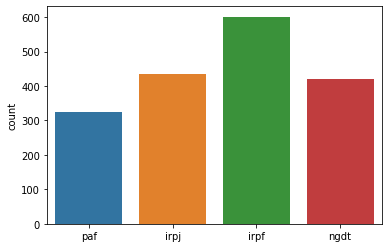

In [ ]:
sns.countplot(rotulos_teste);

In [ ]:
#rotulos para o gráfico matriz de confusão
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']

In [ ]:
rotulos_teste[rotulos_teste == 'irpj'] = 0
rotulos_teste[rotulos_teste == 'irpf'] = 1
rotulos_teste[rotulos_teste == 'ngdt'] = 2
rotulos_teste[rotulos_teste == 'paf'] = 3
rotulos_teste = rotulos_teste.astype(np.int32)
rotulos_teste

array([3, 0, 1, ..., 3, 3, 0], dtype=int32)

## Avaliação do sumarizador Luhn com o modelo da rede neural convolucional

In [ ]:
#Carregando modelo treinado que foi salvo no drive.
Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_lema')

In [ ]:
#Verificando a arquitetura do modelo
Dcnn.summary()

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  6323400   
_________________________________________________________________
conv1d_3 (Conv1D)            multiple                  40100     
_________________________________________________________________
conv1d_4 (Conv1D)            multiple                  60100     
_________________________________________________________________
conv1d_5 (Conv1D)            multiple                  80100     
_________________________________________________________________
global_max_pooling1d_1 (Glob multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  77056     
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0      

In [ ]:
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

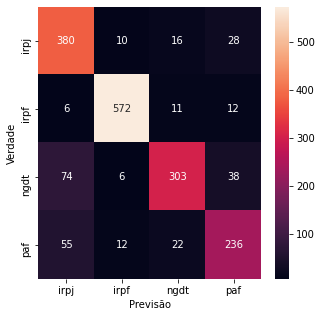

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.837170129140932